# Semantic Segmentation Introduction

In this exercise, we introduce "Semantic Segmentation" of images. Semantic segmentation is a type of classification in which every pixel of an image is labeled with a specific class. Semantic segmentation corresponds to classic image classification in the field of Remote Sensing and Earth Observation. Common applications of Semantic Segmentation include Self Driving Cars that require classifying all objects and pixels of an image to localize objects such as car, pedestrian, road signs, curbs etc.

In this exercise, we use visible airbone imagery from the State of Massachussets. The goal is to detect buildings by predicting pixels that are part of buildings.  

## Dataset

The remote sensing images contains three bands in the visible spectrum: Red, Blue, Green.  There were originally made available by MASSGIS (https://www.mass.gov/orgs/massgis-bureau-of-geographic-information). In this exercise, we are using a common machine learning dataset found in the literature and provided by Volodymyr Mnih as part of his PhD thesis (https://www.cs.toronto.edu/~vmnih/data/).

Images were processed and resampled at 1 meter spatial resolution with tiles/scenes covering 2.24 km2.There are 151 images provided with:
- 137 for training 
- 10 for testing 
- 4 validation 

Targets were generated by rasterizing footprint from Open Street Map.

## Interesting links:

- Image channel order:
https://machinelearningmastery.com/a-gentle-introduction-to-channels-first-and-channels-last-image-formats-for-deep-learning/

- rasterio reclassification:
https://www.earthdatascience.org/courses/use-data-open-source-python/intro-raster-data-python/raster-data-processing/classify-plot-raster-data-in-python/

- https://medium.com/analytics-vidhya/applying-deep-learning-on-satellite-imagery-951faa0cbb31

- Access google drive and GCS:
https://colab.research.google.com/notebooks/io.ipynb#scrollTo=RWSJpsyKqHjH

- Intro to basic Vector GIS:
https://colab.research.google.com/github/bwsi-hadr/03-Intro-to-GIS/blob/master/03_Intro_to_GIS.ipynb#scrollTo=U1VkoUkxZVeg

- UNET model: 
https://colab.research.google.com/github/csaybar/EEwPython/blob/master/cnn_demo.ipynb#scrollTo=nCKDMdr0oXrf
     

In [ ]:
#set up libararies for GIS/Geospatial
try: # try the following block of code
  import geopandas as gpd
except: # if the try block throws an error, run the following
  !pip install geopandas # install geopandas
  import geopandas as gpd
  
try:
  import contextily as ctx # import
except:
  !apt install libproj-dev proj-data proj-bin
  !apt install libgeos-dev
  !pip install cython
  !pip install cartopy
  !pip install contextily==1.0rc1 --no-use-pep517 --no-cache-dir
import contextily as ctx # library for providing background maps
import fiona # library for reading/writing GIS files, comes w/ geopandas
from shapely.geometry import Point, LineString, Polygon

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 14.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 87.2 MB/s eta 0:00:00
Reading package lists... Done
Building dependency tree       
Reading state information... Done
libproj-dev is already the newest version (7.2.1-1~focal0).
libproj-dev set to manually installed.
proj-data is already the newest version (7.2.1-1~focal0).
proj-data set to manually installed.
The following NEW packages will be installed:
  proj-bin
0 upgraded, 1 newly installed, 0 to remove and 23 not upgraded.
Need to get 170 kB of archives.
After this operation, 485 kB of additional disk space will be used.
Get:1 http://ppa.launchpad.net/ubuntugis/ppa/ubuntu focal/main amd64 proj-bin amd64 7.2.1-1~focal0 [170 kB]
Fetched 170 kB in 1s (282 kB/s)
Selecting p

In [ ]:
!pip install rasterio
!pip install pyproj
!apt install unzip

#https://colab.research.google.com/github/bwsi-hadr/03-Intro-to-GIS/blob/master/03_Intro_to_GIS.ipynb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
unzip is already the newest version (6.0-25ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 23 not upgraded.


In [ ]:

###### Library used in this script
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib import colors
import matplotlib.patches as mpatches
import seaborn as sns

import numpy as np
import subprocess
import pandas as pd
import os, glob
import zipfile

# Mapping,vector related imports
import geopandas as gpd
#import descartes #nessary for plotting in geopandas
from cartopy import crs as ccrs
from pyproj import Proj
#from osgeo import osr
from shapely.geometry import Point
from shapely.geometry import box
from collections import OrderedDict

#ML imports
import sklearn
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

#rasterio imports, gdal and imagery utility
import rasterio
from rasterio.windows import Window
from osgeo import gdal
from rasterio import plot
from PIL import Image

#Keras import
from tensorflow import keras
#from keras.models import Model

from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Conv2D, Concatenate, Activation, MaxPool2D, UpSampling2D, Conv2DTranspose
from tensorflow.keras import models
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model


sns.set_style('darkgrid')
pd.set_option('display.max_colwidth', None)

The packages above are some of the most frequently used for geospatial data processing, wrangling and analysis. Notables packages are geopandas, rasterio, pysal, gdal and shapely. Geopandas extends the pandas package to allow for the use of spatial data using a geometry column in a DataFrame. It implements a version of the Simple Feature model (https://www.opengeospatial.org/standards/sfa) using the "shapely" package to define the geometry of spatial objects. GDAL and Rasterio allows operations and processing on raster layers. Pysal provide spatial analyses tools such as Moran's I and spatial regression modeling. In this exercise, we also use the "keras" package that implements deep learning models at high abstraction level.

## Functions
In the next part of the script, we declare all the functions used in the sripts.  It is good practice to place functions at the beginning of a script or in an external source file. Here are the functions used:

* **create_dir_and_check_existence**:  create and output directory given a path. The output directory will be the working directory throughout the analysis.

* **generate_files_data_df**: generate a list of image files with path and type. There are three types of files used in this application: training, testing and validation. Each RGB image (X input) has corresponding target image Y (output).
We used the file structure from Volodymyr Mnih (https://www.cs.toronto.edu/~vmnih/data/).)

* **generate_image_chips**; generate image chips/patches that are in this script 256x256 cropped images taken randomly within the remotely sensed images. These image chips are used to train, validate and test the deep learning model.

* **image_data_generator**: generate batch of data to use in the deep learning model. The dataset being to large, an image chip is provided one at a time when fiting the deep learning model.

* **plot_roc**: generate ROC plots using a reference and a predicted image. AUC 
values are also returned for testing and training if provided.

* **compute_iou_dice_metrics**: geneate IOU (aka Jaccard index) and dice metrics to evaluate the classification. 

* **binary_crosstab_array**: generate error map for boolean (0,1) reference and predicted raster (input format as np.array).



In [ ]:
def create_dir_and_check_existence(path):
    
    #Create a new directory
    try:
        os.makedirs(path)
    except:
        print ("directory already exists")

from matplotlib import pyplot


def generate_files_data_df(in_path):
    """
    Generate data frame for the input raster files. This function assumes a specific directory tree structure.
    We use the structure from provided by Volodymyr Mnih as part of his PhD thesis (https://www.cs.toronto.edu/~vmnih/data/).
    This data is also used in numerous publication. The data frame will contain for each scene id, a corresponding
    sat (RGB aerial imagery) and map (classfied building image) as well as label named 'type' corresponding to
    train, test, and validation data.

    Input Arguments:

    in_path: parent directory path to the data files

    Return Outputs:

    files_df: pandas data frame containing directory path to training, testing and validation images.

    """

    fileglob = "*.tiff"
    path_raster_sat = os.path.join(in_path+'/**/sat/',fileglob) #raw raster
    fileglob = "*.tif"
    path_raster_map = os.path.join(in_path+'/**/map/',fileglob) #classified

    files_raster_sat = glob.glob(path_raster_sat,recursive=True)
    files_raster_map = glob.glob(path_raster_map,recursive=True)

    files_map_df = pd.DataFrame({'files_map':files_raster_map})
    files_sat_df = pd.DataFrame({'files_sat':files_raster_sat}) 
 
    files_sat_df['scene_id_sat'] = files_sat_df['files_sat'].apply(lambda x: os.path.basename(x).replace('.tiff',""))
    files_map_df['scene_id_map'] = files_map_df['files_map'].apply(lambda x: os.path.basename(x).replace('.tif',""))

    files_df = (files_sat_df.merge(files_map_df,
                                  left_on='scene_id_sat',
                                  right_on='scene_id_map',
                                  how='inner')
                             .drop(columns=['scene_id_map'])
                             .rename(columns={'scene_id_sat':'scene_id'})
               )
    files_df['type']= files_df['files_sat'].apply(lambda x: os.path.basename(os.path.dirname(os.path.dirname(x)))) #make it more elegant later
    
    return files_df



In [ ]:


def generate_image_chips(in_file,
                         image_size=32,
                         row_offset=None,
                         col_offset=None,
                         rescale=None,
                         out_file=None,
                         shape_file=None,
                         plot=False):
    '''
    This function generates image subsets called chips given an input file and a series of arguments.

    Input Arguments:

    in_file: input file name, this assumes 3 bands
    image_size: default size (height=width) for the image chip/subset produced.
    row_offset: row/height offset provided, if none this is generated on the fly randomly 
    col_offset: col/width offset provided, if none this is generated on the fly randomly 
    rescale: not implemented yet, option to rescale the image, default is None
    out_file: not implemented yet, option to save the image chip, default is None
    shape_file: not implemented yet,option to use a shape file to crop the image and generate chip, default is None
    plot: generate plot using RGB bands, default option is False

    Return Outputs:

    w_image: chip/cropped image with size image_size x image_size return as a numpy array with 3 channels/bands
    df_chip: pandas data frame containing meta data including row and column offset
             used in sampling the image chip as well as
             the coordinates of the extent/bounding box of the image chip,
             original file used and the scene id.

    '''
   
    raster = rasterio.open(in_file)
    height_val = raster.height #row in remote sensing image
    width_val  = raster.width  #col in remote sensing image
    channel_val = raster.count #band in remote sensing image
    
    if row_offset is None:
        limit_row = height_val - image_size #the new image chip cannot exceed the limit of the image otherwise it will not have the expected size
        row_offset = np.random.randint(0,
                                       limit_row, 
                                       size=1)

    if col_offset is None:
        limit_col = width_val - image_size #the new image chip cannot exceed the limit of the image otherwise it will not have the expected size
        col_offset = np.random.randint(0, 
                                       limit_col, 
                                       size=1)

    channel_list = np.arange(1,channel_val+1).tolist()
    
    if shape_file==None:
        with rasterio.open(in_file) as src:
            w_image = src.read(channel_list,
                  window=Window(row_offset,
                                col_offset, 
                                image_size, 
                                image_size))
    scene_id=os.path.basename(in_file)

    if plot==True:
        #Generate quick visualization using rasterio object
        f, ax = plt.subplots(1, 3,figsize=(16,16))

        rasterio.plot.show(w_image[0],title=scene_id+" band_1",ax=ax[0])
        rasterio.plot.show(w_image[1],title=scene_id+" band_2",ax=ax[1])
        rasterio.plot.show(w_image[2],title=scene_id+" band_3",ax=ax[2])
    
    #Finish this option later
    #if out_file!= None:
    #    w_image.write
    
    if rescale is not None:
        w_image = w_image.astype('float64')
        for i in range(0,len(channel_list)):
            w_image[i,:,:] = w_image[i,:,:] * rescale

    if isinstance(row_offset,np.ndarray):
        row_offset= row_offset[0]
    if isinstance(col_offset,np.ndarray):
        col_offset= col_offset[0]

    x_offset_l_top,y_offset_l_top = raster.xy(row_offset,
                                              col_offset) #topleft of image chip
    x_offset_r_bottom,y_offset_r_bottom = raster.xy(row_offset+image_size,
                                                    col_offset+image_size)
    
    df_chip=pd.DataFrame({"scene_id":[scene_id],
                          "col_offset":[col_offset],
                          "row_offset":[row_offset],
                          "image_size":[image_size],
                          "x_min": [x_offset_l_top],
                          "y_min": [y_offset_l_top],
                          "x_max": [x_offset_r_bottom],
                          "y_max": [y_offset_r_bottom],
                          "file":[in_file]})
    return w_image, df_chip

In [ ]:


def image_data_generator(image_files_df,subset="train",rescale=1./255,image_size=256,batch_size=32):
    '''
    This is an image data generator for spatial images. It uses rasterio window to sample randomly image chips and return images.
    to train/validate/test a network.
    Note that this function assumes a specific format for the input data frame used to describe the data.
    The data frame should contain four columns: files_map,files_sat, scene_id and type.
    
    Input Arguments:

    image_files_df: data frame containing the path names for input features, target and type
    subset: subset data frame for training, validation or testing, default is "train", selected using column 'type'.
    rescale: rescale factor for the input images, default is 1./255
    image_size: image size generated from input by subset, default is 256 (height=width)
    batch_size: number of batches, default is 32    
    
    Return Outputs:

    batch_image_X: Input feature numpy array containing batch of image arrays (height, width, channel) 
    batch_image_Y: Target nnumpy array containing batch of image arrays (height, width, channel) 

    '''
    
    while True:
        in_files_df = (image_files_df.loc[image_files_df['type']==subset,:]
                                     .sample(n = batch_size)
                      )

        list_w_image_X = []
        list_w_image_Y = []
        list_df_chip_X = []
        list_df_chip_Y = []
        
        for i in range(0,batch_size):
            w_image_X, df_chip_X = generate_image_chips(in_files_df['files_sat'].iloc[i],
                             image_size=image_size,
                             row_offset=None,
                             col_offset=None,
                             rescale=1./255.,
                             out_file=None,
                             shape_file=None,
                             plot=False)
            # for Y:
            w_image_Y, df_chip_Y = generate_image_chips(in_files_df['files_map'].iloc[i],
                             image_size=image_size,
                             row_offset=df_chip_X['row_offset'].iloc[0],#use offset from input feature images
                             col_offset=df_chip_X['col_offset'].iloc[0],
                             rescale=1./255.,
                             out_file=None,
                             shape_file=None,
                             plot=False)
            
            if rescale is not None:
                #not yet implemented
                print()
                channel_val = raster.count #band
                channel_list = np.arange(1,channel_val+1).tolist()

                w_image = w_image.astype('float64')
                for i in range(0,len(channel_list)):
                  w_image_X[i,:,:] = w_image_X[i,:,:] * rescale

                
            list_w_image_X.append(w_image_X)
            list_w_image_Y.append(w_image_Y)
            list_df_chip_X.append(df_chip_X)
            list_df_chip_Y.append(df_chip_Y)
            
        #return only images, 
        batch_image_X=np.stack(list_w_image_X)
        batch_image_Y=np.stack(list_w_image_Y)

        batch_image_X = np.moveaxis(batch_image_X, 1, 3) #move axis 1 to 3, i.e. channel axis should be last.
        batch_image_Y = np.moveaxis(batch_image_Y, 1, 3) #move axis 1 to 3, this is necessary later for keras.
        #batch_image_Y = batch_image_Y[:,:,:,0] #this removes the fourth dimension
        batch_image_Y = batch_image_Y[:,:,:,:1]
        
        yield  batch_image_X, batch_image_Y


In [ ]:
def plot_roc(y_test,
             y_scores_test,
             y_scores_train=None,
             y_train=None,
             model_name=None,
             show_fig=True,
             out_file=None):
    '''
    This functions gnerate an ROC plot curve and AUC metric.
    
    Input Arguments:

    y_test: input one dimension array containing test label/target
    y_scores_test: input one dimension array containing predicted test scores (between 0 and 1)
    y_scores_train: input one dimension array containing predicted train scores (between 0 and 1),
                    default is None
    y_train:input one dimension array containing train scores (between 0 and 1),
            default is None.
    model_name: string containing model name (e.g. UNET), default is None
    show_fig:if True, ROC plot is shown.
    out_file: name of output file for ROC plot
              if None, a default name is set.
    
    Return Outputs:

    roc_df: DataFrame with three columns: threshold, False Positive Rate (fpr) and True Positive Rate (tpr)
    auc_df: DataFrame with three columns: test AUC ('test', train AUC ('train'),model name ('model')

    '''

    if model_name is None:
        model_name = 'model'
    # Now check the number of 1 and 0 
    unique, counts = np.unique(y_test, return_counts=True)
    if len(unique) > 1:
      auc_val_test =roc_auc_score(y_test,y_scores_test)
    else: 
      auc_val_test = np.nan
    
    if y_scores_train is None:    
        auc_val_train = np.nan
    elif y_train is None:
        auc_val_train = np.nan
    else:
        auc_val_train = roc_auc_score(y_train,
                                      y_scores_train)
        
    if len(unique) > 1:
      print("AUC train: ", auc_val_train)
      print("AUC test: ", auc_val_test)

      #Generate inputs for ROC curves
      fpr, tpr, thresholds = roc_curve(y_test, 
                                     y_scores_test)
      plt.figure()
      label_val = '%s (area= %0.2f)' % (model_name,auc_val_test)
    
      plt.plot(fpr, tpr, 
             label=label_val)

      plt.plot([0, 1], [0, 1],'r--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Test ROC')
      plt.legend(loc="lower right")
    else:
      thresholds = [np.nan]
      tpr= [np.nan]
      fpr = [np.nan]

    if out_file is None:
       out_file = model_name + '_roc_curve.png'
    
    plt.savefig(out_file)
    
    if show_fig == True:
        plt.show()
    else:
        plt.close()
    
    roc_df = pd.DataFrame({'thresholds': thresholds,
                           'tpr': tpr,
                           'fpr': fpr})
    
    auc_df = pd.DataFrame(np.array([[auc_val_test],[auc_val_train],[model_name]]).reshape(1,3),
                         columns=['test','train','model'])

    return roc_df, auc_df


def plot_roc(y_test,
             y_scores_test,
             y_scores_train=None,
             y_train=None,
             model_name=None,
             show_fig=True,
             out_file=None):
    '''
    This functions gnerate an ROC plot curve and AUC metric.
    
    Input Arguments:

    y_test: input one dimension array containing test label/target
    y_scores_test: input one dimension array containing predicted test scores (between 0 and 1)
    y_scores_train: input one dimension array containing predicted train scores (between 0 and 1),
                    default is None
    y_train:input one dimension array containing train scores (between 0 and 1),
            default is None.
    model_name: string containing model name (e.g. UNET), default is None
    show_fig:if True, ROC plot is shown.
    out_file: name of output file for ROC plot
              if None, a default name is set.
    
    Return Outputs:

    roc_df: DataFrame with three columns: threshold, False Positive Rate (fpr) and True Positive Rate (tpr)
    auc_df: DataFrame with three columns: test AUC ('test', train AUC ('train'),model name ('model')

    '''

    if model_name is None:
        model_name = 'model'
    # Now check the number of 1 and 0 
    unique, counts = np.unique(y_test, return_counts=True)
    if len(unique) > 1:
      auc_val_test =roc_auc_score(y_test,y_scores_test)
    else: 
      auc_val_test = np.nan
    
    if y_scores_train is None:    
        auc_val_train = np.nan
    elif y_train is None:
        auc_val_train = np.nan
    else:
        auc_val_train = roc_auc_score(y_train,
                                      y_scores_train)
        
    if len(unique) > 1:
      print("AUC train: ", auc_val_train)
      print("AUC test: ", auc_val_test)

      #Generate inputs for ROC curves
      fpr, tpr, thresholds = roc_curve(y_test, 
                                     y_scores_test)
      plt.figure()
      label_val = '%s (area= %0.2f)' % (model_name,auc_val_test)
    
      plt.plot(fpr, tpr, 
             label=label_val)

      plt.plot([0, 1], [0, 1],'r--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Test ROC')
      plt.legend(loc="lower right")
    else:
      thresholds = [np.nan]
      tpr= [np.nan]
      fpr = [np.nan]

    if out_file is None:
       out_file = model_name + '_roc_curve.png'
    
    plt.savefig(out_file)
    
    if show_fig == True:
        plt.show()
    else:
        plt.close()
    
    roc_df = pd.DataFrame({'thresholds': thresholds,
                           'tpr': tpr,
                           'fpr': fpr})
    
    auc_df = pd.DataFrame(np.array([[auc_val_test],[auc_val_train],[model_name]]).reshape(1,3),
                         columns=['test','train','model'])

    return roc_df, auc_df

In [ ]:
#Original code from coursera for iou and dice scores, 
#Modified by Benoit to fix some issues, especially nan related
def compute_iou_dice_metrics(y_true, y_pred,n_classes=2):
  '''
  Computes IOU and Dice Score.

  Args:
    y_true (tensor) - ground truth label map
    y_pred (tensor) - predicted label map
  '''
  
  class_iou = []
  class_dice_score = []

  unique, counts = np.unique(y_true, return_counts=True)
  if len(unique) > 1:
    smoothening_factor = 0.00001 #avoid if there is a class with zero frequency
    #np.unique(y_true)
    for i in np.arange(0,n_classes):
      intersection = np.sum((y_pred == i) * (y_true == i))
      y_true_area = np.sum((y_true == i))
      y_pred_area = np.sum((y_pred == i))
      combined_area = y_true_area + y_pred_area
    
      iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
      class_iou.append(iou)
    
      dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
      class_dice_score.append(dice_score)
  else:
    for i in np.arange(0,n_classes):
      iou=np.nan
      dice_score=np.nan
      class_dice_score.append(dice_score)
      class_iou.append(iou)

  return class_iou, class_dice_score

In [ ]:
def binary_crosstab_array(arr1,arr2):
  
  """
  This function generates a crosstab numpy array given two input arrays.
  The first array 'arr1' can be taken as a reference to which the
  second array (arr2) is compared. One can think of arr2 as the prediction.
  Note that the arrays are assumed to be boolean with values 0 or 1.
  The output is a new array with four values 0,1,2,3 corresponding respectively
  to True Negative (TN), True Positive (TP), False Positive (FP) and False Negative (FN).

  TO DO:   Add later testing for number of rows and cols matching to avoid error

  Input Arguments: 
  arr1: reference array (numpy type)
  arr2: predicted array (numpy type)

  Return Outputs:
  arr_new: reclassified output array with confusion matrix including TP, TN,FP, FN
  df_label_new: data frame with values and corresponding labels used in arr_new

  """
    
  row,col = arr1.shape #get height/row and width/col
    
  arr_new = np.empty(arr1.shape, dtype=int) #new output array with values reclassified as TN,TP,FP,FN

  for i in range(0,row):
    for j in range(0,col):
      if (arr1[i,j]==arr2[i,j]) and (arr1[i,j]==0) :
        arr_new[i,j]=0 #True Negative (TN)
      if (arr1[i,j]==arr2[i,j]) and (arr1[i,j]==1) :
        arr_new[i,j]=1 #True Positive (TP)
      if (arr1[i,j]!=arr2[i,j]) and (arr1[i,j]==0) :
        arr_new[i,j]=2 # False Positive (FP)
      if (arr1[i,j]!=arr2[i,j]) and (arr1[i,j]==1) :
        arr_new[i,j]=3 # False Negative (FN)
     
  df_label_new = pd.DataFrame({"val": [0,1,2,3],
                                "label":["TN","TP","FP","FN"]
                              })
  return arr_new, df_label_new            


In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')

Mounted at /content/gdrive


## Parameters and Arguments

It is good practice to set all parameters and input arguments at the beginning of the script. This allows for better control and can make modifications of the scripts for other applications easier. Some arguments relate to path directories, input files and general parameters for use in the analyses (e.g. proportion of hold out).


In [ ]:
############################################################################
#####  Parameters and argument set up ########### 

#ARG 1
in_dir = '/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/'
#ARG 2
out_dir = "/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation"
#ARGS 3:
create_out_dir=True #create a new ouput dir if TRUE
#ARG 4
out_suffix = "semantic_seg_03202023" #output suffix for the files and ouptut folder
#ARG 5
NA_value = -9999 # currently not used: Nan value
#ARG 6
random_seed=105 # set seed for reproducibility of results

#ARG 7   
## Input data
data_dir ='/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data'
#ARG 8
run_model = False #if True, model is trained, note this may take several hours.
#ARG 9
# Use pre-trained model if run_model is False
model_path ='/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/models/output_data_semantic_seg_03092021/model_semantic_segmentation_build_semantic_seg_03092021.h5'


In [ ]:
################# START SCRIPT ###############################

######### PART 0: Set up the output dir ################

#set up the working directory
#Create output directory

if create_out_dir==True:
    out_dir_new = "output_data_"+out_suffix
    out_dir = os.path.join(out_dir,"outputs",out_dir_new)
    create_dir_and_check_existence(out_dir)
    os.chdir(out_dir)        #set working directory
else:
    os.chdir(out_dir) #use working dir defined earlier


directory already exists


In [ ]:
print(out_dir)

/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/outputs/output_data_semantic_seg_03202023


# Workflow/pipeline

We describe here the modeling pipelin we set up for this exercise:
1. **Download** 
- Obtain data from the website or link provided in the exercise.
2. **Explore data and set up list**
- Prepare data frame with list of files as input in the training and for the generator.
-Visualize feature images and target image.
3. **Generate image chip/patch data for training and modeling**
- use the image data generator to generate image chips to feed in during the model fitting/training.
4. **Build and train model**
- build UNET keras model
- train model using the image data generator
5. **Accuracy Assessment**
- use test data to generate an accuracy assessment
- assess accuracy with ROC plot and AUC.



# 1.Download/Unzip Data

Dowload data from the following google drive link. Once it is downloaded, you will need to place and upload the zipped file in your own google drive directory. The suggested path for the zipped file 'mass_building.zip' is in '/intro_semantic_segmentation/data/.

### Data structure

The data is organized in three main directories: train, test and valid.
The map 'directory' contains classified boolean image (with 0 not build and 1 being built) and 'sat' contains the RBG aerial imagery in tiff format. Every image contains a scene id with matching scene id in the map directory.
Once unzipped, you should be able to see the following directory tree structure:
 
```
mass_buildings/
            /train/
                  /map/<scene_id>.tif
                  /sat/<scene_id>.tif
            /test
                 /map/<scene_id>.tif
                 /sat/<scene_id>.tif
            /valid
                 /map/<scene_id>.tif
                 /sat/<scene_id>.tif
```

In [ ]:
#extract data using zipfile

zip = zipfile.ZipFile(os.path.join(data_dir,'mass_buildings.zip'))
zip.extractall(data_dir)
data_dir = os.path.join(data_dir, "mass_buildings")


#2.Explore data display images

In [ ]:
files_df = generate_files_data_df(data_dir)
files_df.head()

,files_sat,scene_id,files_map,type
0,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/sat/22978945_15.tiff,22978945_15,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/map/22978945_15.tif,valid
1,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/sat/23579050_15.tiff,23579050_15,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/map/23579050_15.tif,valid
2,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/sat/23728930_15.tiff,23728930_15,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/map/23728930_15.tif,valid
3,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/sat/23429155_15.tiff,23429155_15,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/map/23429155_15.tif,valid
4,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/test/sat/22829050_15.tiff,22829050_15,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/test/map/22829050_15.tif,test


In [ ]:
files_df.type.value_counts()

train    137
test      10
valid      4
Name: type, dtype: int64

In [ ]:
print(files_df.loc[0,['files_sat']])
print(files_df.loc[0,['files_map']])
print(files_df.loc[0,['scene_id']])

files_sat    /content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/sat/22978945_15.tiff
Name: 0, dtype: object
files_map    /content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/map/22978945_15.tif
Name: 0, dtype: object
scene_id    22978945_15
Name: 0, dtype: object


In [ ]:
r_sat = rasterio.open(files_df['files_sat'][0])
r_map = rasterio.open(files_df['files_map'][0])
scene_id = files_df.loc[0,['scene_id']]
print(type(r_sat))
print("Coordinate reference system: ",r_sat.crs ) 
print(type(r_map))
print("Coordinate reference system: ",r_map.crs ) 
print(" Rows and columns: ", r_sat.shape, "number of rows/height: ", r_sat.height, "number of columns/width",r_sat.width)  


<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  EPSG:26986
<class 'rasterio.io.DatasetReader'>
Coordinate reference system:  EPSG:26986
 Rows and columns:  (1500, 1500) number of rows/height:  1500 number of columns/width 1500


In [ ]:
print(type(r_sat.meta))
r_sat.meta

<class 'dict'>


{'driver': 'GTiff',
 'dtype': 'uint8',
 'nodata': None,
 'width': 1500,
 'height': 1500,
 'count': 3,
 'crs': CRS.from_epsg(26986),
 'transform': Affine(1.0000000000000195, 0.0, 228986.4361739957,
        0.0, -0.9999999999999225, 895271.0247782532)}

<Axes: title={'center': 'scene_id_mapped'}>

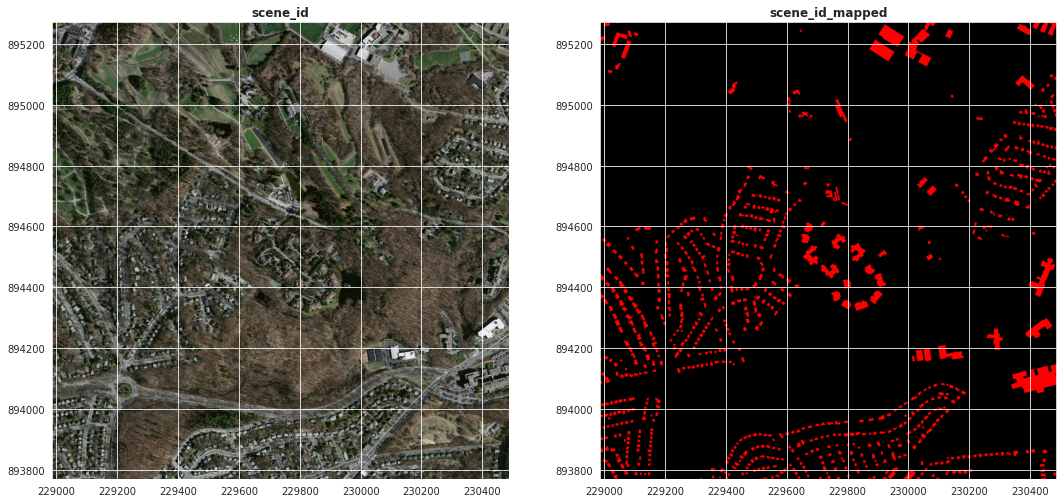

In [ ]:
#Generate quick visualization using rasterio object
scene_id="scene_id"
f, ax = plt.subplots(1, 2,figsize=(18,18))
plot.show(r_sat,title=scene_id,ax=ax[0])
plot.show(r_map,title=scene_id+"_mapped",ax=ax[1])

In [ ]:
arr = r_sat.read()  # read all raster values as numpy array
display(type(arr))
arr.shape

numpy.ndarray

(3, 1500, 1500)

In [ ]:
arr = r_map.read()  # read all raster values
display(type(arr))
arr.shape

numpy.ndarray

(3, 1500, 1500)

In [ ]:
unique_elements, counts_elements = np.unique(arr[0,:,:], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Frequency of unique values of the said array:
[[      0     255]
 [2115685  134315]]


In [ ]:
unique_elements, counts_elements = np.unique(arr[1,:,:], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))


Frequency of unique values of the said array:
[[      0]
 [2250000]]


In [ ]:
unique_elements, counts_elements = np.unique(arr[2,:,:], return_counts=True)
print("Frequency of unique values of the said array:")
print(np.asarray((unique_elements, counts_elements)))

Frequency of unique values of the said array:
[[      0]
 [2250000]]


#3.Generate image chip/patch data for training and modeling
This includes two steps:
1. generate images chips
2. include image chips in a generator

(3, 256, 256)

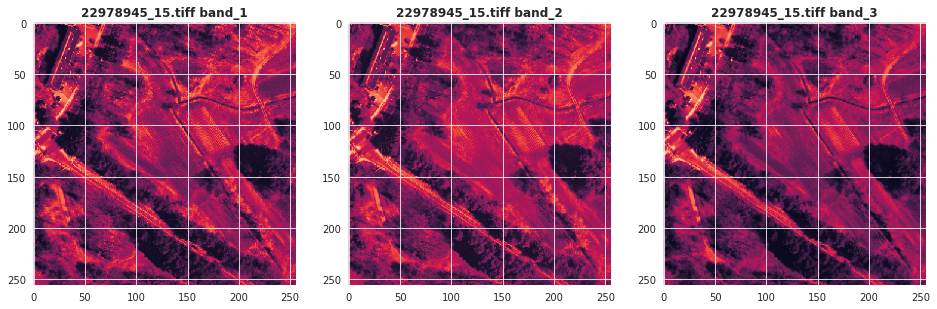

In [ ]:
test,df_chip=generate_image_chips(in_file=files_df.files_sat[0],
                                  image_size=256,
                                  row_offset=55,
                                  col_offset=55,
                                  rescale=1./255.,
                                  out_file=None,
                                  shape_file=None,
                                  plot=True)
test.shape

<Axes: title={'center': 'Image subset generated'}>

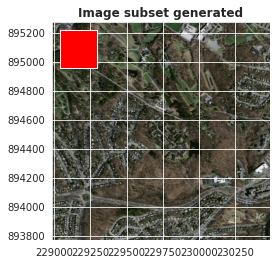

In [ ]:
#use box from shapely.geometry
b = df_chip.apply(lambda row: box(row.x_min, #also called left
                                  row.y_min, #also called bottom
                                  row.x_max, #also called right
                                  row.y_max, #also called top
                                  ccw=True), 
                  axis=1)
gdf = gpd.GeoDataFrame(df_chip, geometry=b)

##### How to combine plots with rasterio package
r_build = rasterio.open(files_df.files_sat[0])
fig, ax = plt.subplots()
rasterio.plot.show(r_build,ax=ax,
                  title="Image subset generated")
gdf.plot(ax=ax,
              color="red")

In [ ]:
df_chip

,scene_id,col_offset,row_offset,image_size,x_min,y_min,x_max,y_max,file,geometry
0,22978945_15.tiff,55,55,256,229041.936174,895215.524778,229297.936174,894959.524778,/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/data/mass_buildings/valid/sat/22978945_15.tiff,"POLYGON ((229297.936 895215.525, 229297.936 894959.525, 229041.936 894959.525, 229041.936 895215.525, 229297.936 895215.525))"


In [ ]:
np.random.seed(random_seed)

train_generator_build = image_data_generator(image_files_df=files_df,
                                             subset="train",
                                             rescale=None,
                                             image_size=256,
                                             batch_size=32) 

Using the image data generator, we can access one item. Note that both the original RGB feature image and target image (buildings mapped) are returned in the form of numpy arrays. This is a four dimensional array with:
- the first dimension corresponding to the number of batches.
- second dimension to the height (row) of the image
- third dimension to the width (column) of the image
- fourth dimension corresponding to the number of channels 

In [ ]:
w_X, w_Y  = next(train_generator_build)
print("input feature dimension: ",w_X.shape)
print(w_Y[0].shape) #select specific batch
print(w_Y[0,:,:,:].shape) #select specific batch
##can't have dimension with channel 1

input feature dimension:  (32, 256, 256, 3)
(256, 256, 1)
(256, 256, 1)


In [ ]:
#To plot the image with matplotlib, we need an image of size height by width (row by col)
w_X[0,:,:,0].shape #this will drop the first and fourth dimension on the fly by selecting element 0


(256, 256)

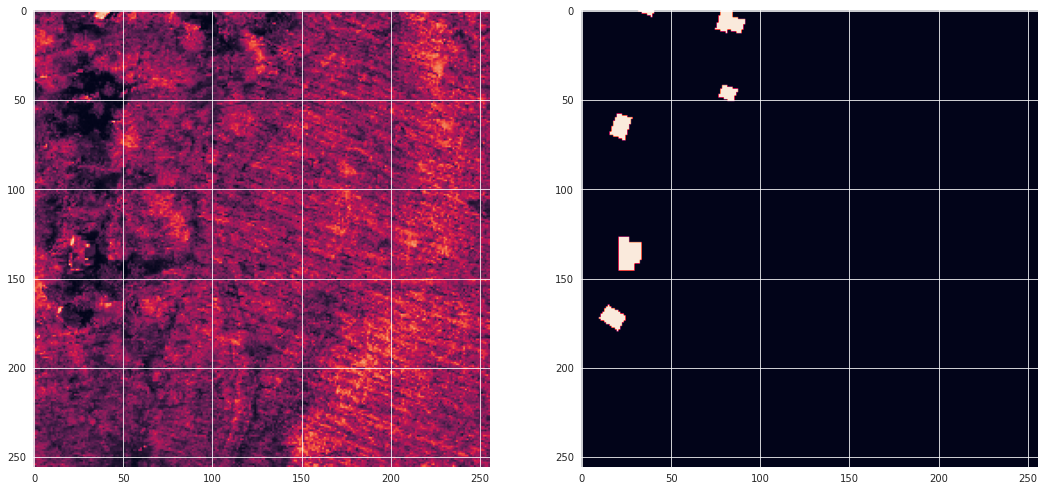

In [ ]:
#Generate quick visualization using rasterio object
scene_id="scene_id"
f, ax = plt.subplots(1, 2,figsize=(18,18))
ax[0].imshow(w_X[0,:,:,0])
ax[1].imshow(w_Y[0,:,:,0])

In [ ]:
print(w_Y[0].min(),w_Y[0].max())#make an histogram
print(w_X[0].min(),w_X[0].max())

0.0 1.0
0.0 0.8196078431372549


#4.Building and training model

The model we are builing in this exercise is called UNET due to the shape of its reprentation (https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/).
![UNET](https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/u-net-architecture.png)

UNET is a form of Fully Convolutional Network with three main parts:
- encoding (compression with pooling)
- decoding (decompression with upsampling)
- classification (CNN layer)

It is a form of autoencoder adapted for pixel level classification. The output layer has the same spatial dimension as the input but with one band/channel corresponding to the probability of a pixel being labeled as 'built'.


In [ ]:
w_X.shape
IMG_SHAPE  = w_X[0].shape
EPOCHS = 10


In [ ]:
w_X[0].shape

(256, 256, 3)

In [ ]:
#from tensorflow.keras import layers
#Reference for Unet model: This is modified from
#https://colab.research.google.com/github/csaybar/EEwPython/blob/master/cnn_demo.ipynb

def conv_block(input_tensor, num_filters):
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(input_tensor)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  encoder = layers.Conv2D(num_filters, (3, 3), padding='same')(encoder)
  encoder = layers.BatchNormalization()(encoder)
  encoder = layers.Activation('relu')(encoder)
  return encoder

def encoder_block(input_tensor, num_filters):
  encoder = conv_block(input_tensor, num_filters)
  encoder_pool = layers.MaxPooling2D((2, 2), strides=(2, 2))(encoder)
  
  return encoder_pool, encoder

def decoder_block(input_tensor, concat_tensor, num_filters):
  decoder = layers.Conv2DTranspose(num_filters, (2, 2), strides=(2, 2), padding='same')(input_tensor)
  decoder = layers.concatenate([concat_tensor, decoder], axis=-1)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  decoder = layers.Conv2D(num_filters, (3, 3), padding='same')(decoder)
  decoder = layers.BatchNormalization()(decoder)
  decoder = layers.Activation('relu')(decoder)
  return decoder

inputs = layers.Input(shape=IMG_SHAPE)
# 256
encoder0_pool, encoder0 = encoder_block(inputs, 32)
# 128
encoder1_pool, encoder1 = encoder_block(encoder0_pool, 64)
# 64
encoder2_pool, encoder2 = encoder_block(encoder1_pool, 128)
# 32
encoder3_pool, encoder3 = encoder_block(encoder2_pool, 256)
#16
# center
center = conv_block(encoder3_pool, 512) #change to 512
#16
decoder3 = decoder_block(center, encoder3, 256)
# 32
decoder2 = decoder_block(decoder3, encoder2, 128)
# 64
decoder1 = decoder_block(decoder2, encoder1, 64)
# 128
decoder0 = decoder_block(decoder1, encoder0, 32)
# 256

outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(decoder0)

In [ ]:
#Need to import: from tensorflow.keras import models
model = models.Model(inputs=[inputs], outputs=[outputs])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 32  128        ['conv2d[0][0]']                 
 alization)                     )                                                             

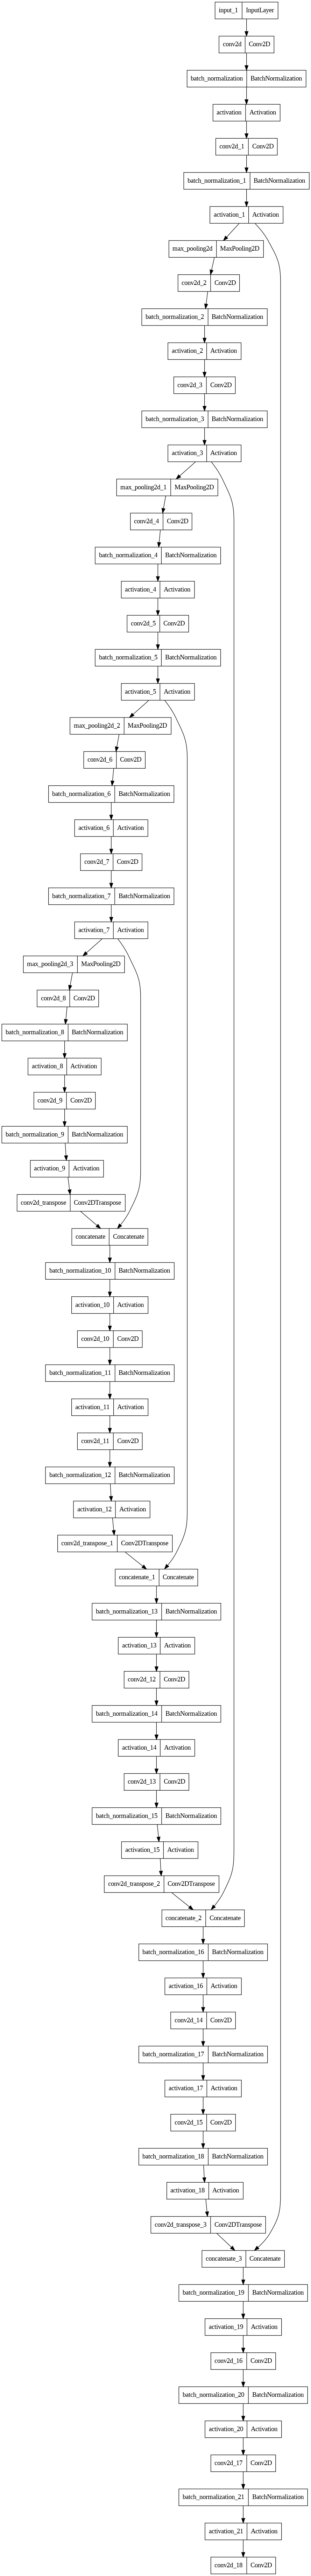

In [ ]:
# use from tensorflow.keras.utils import plot_model
plot_model(model,"model.png") # this is from tensorflow.keras.utils
#requires graphviz
#sudo apt install graphviz

In [ ]:
#model.compile(optimizer='adam', loss=bce_dice_loss, metrics=[dice_loss])
model.compile(optimizer='adam', loss="binary_crossentropy")

In [ ]:
loss = model.train_on_batch(w_X,w_Y)

In [ ]:
loss

1.1643167734146118

In [ ]:
model.fit(train_generator_build, steps_per_epoch=2, epochs=2)


Epoch 1/2
2/2 [==============================] - 25s 10s/step - loss: 0.9839
Epoch 2/2
2/2 [==============================] - 20s 10s/step - loss: 0.8606


In [ ]:
#if run_model=True then train model and store weights and history 
if run_model==True:
    history=model.fit_generator(train_generator_build, 
                                steps_per_epoch=16, 
                                epochs=50)
    # convert the history.history dict to a pandas DataFrame:     
    hist_df = pd.DataFrame(history.history) 

    # save to json:  
    hist_json_file = 'history.json' 
    with open(hist_json_file, mode='w') as f:
        hist_df.to_json(f)
    # save to csv: 
    hist_csv_file = 'history.csv'
    with open(hist_csv_file, mode='w') as f:
        hist_df.to_csv(f)
    # serialize weights to HDF5
    model.save_weights('model_semantic_segmentation_build_'+out_suffix+'.h5')
    #model.save_weights('my_model_weights.h5')

    print("Saved model to disk")

In [ ]:
#if run_model=False then load models weights and loss history from h5 file
if run_model==False:
    if model_path is not None:
        model.load_weights(model_path)
    if model_path is None:
        fileglob = "*.h5"
        model_path = os.path.join(out_dir,fileglob) #classified
        file_model_path = glob.glob(model_path,recursive=False)
        model.load_weights(file_model_path[0])


In [ ]:
print(model_path)

/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/models/output_data_semantic_seg_03092021/model_semantic_segmentation_build_semantic_seg_03092021.h5


In [ ]:
# Get information on loss a a function of epoch
path_dir = os.path.dirname(model_path)
fileglob = "*.csv"
history_model_filename = os.path.join(path_dir,fileglob) #classified
history_model_path = glob.glob(history_model_filename,recursive=False)
print(history_model_path)
# add plot of history loss
loss_acc_fit = pd.read_csv(history_model_path[0])
loss_acc_fit.rename(columns={"Unamed: 0":"epoch"},inplace=True)
loss_acc_fit.head()


['/content/gdrive/MyDrive/Colab Notebooks/deep_learning_with_satellite_and_geospatial_data_course/intro_semantic_segmentation/models/output_data_semantic_seg_03092021/history.csv']


,Unnamed: 0,loss
0,0,0.417112
1,1,0.314329
2,2,0.280627
3,3,0.258950
4,4,0.246936


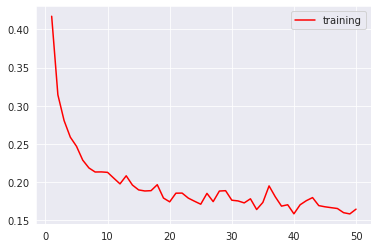

In [ ]:
#Plotting loss in term of epoch. This helps in understanding how the model is converging or improving.
n_epoch= loss_acc_fit.shape[0]
fig, ax = plt.subplots()
ax.plot(range(1,n_epoch+1),loss_acc_fit['loss'],
        color="red",label="training")
ax.legend()

# 5.Accurary Assessment and model evaluation

We will assess the model using the test data. The steps as follow:

1. generate test samples and predict using the fitted model
2. visualize outputs as raster map
3. compute accuracy metrics using the ROC and AUC.
4. examine precision and recall for specific threshold
5. create a precision-recall curve
6. produce a IOU metric

In #1, we generate new image chips using test image data with the image data generator used earlier. For this exercise, we will generate 10 samples but more can be generated if we wish to increase the number of test samples. We can then predct for each pixel a score representing the probabily of belonging to the class 'built'.

In #2, we visualize the new prediction. First,we visualize the output probabilities from the model 
(continuous value between 0 and 1). Second, we generate class prediction by using by setting the treshold to 0.5. Any pixel with probability higher than
0.5 is classified as building. A boolean map of error is generated to visualize the matrix of confusion at the pixel level.

In #3, we compute the ROC and AUC for all 10 test chip image. We also generate ROC plots and save results in a data frame.

In [ ]:
test_generator_build = image_data_generator(image_files_df=files_df,
                     subset="test",
                     #rescale=1./255,
                     rescale=None,
                     image_size=256,
                     batch_size=10)#only 10 images

In [ ]:
w_X_test, w_Y_test  = next(test_generator_build)
w_X_test.shape

(10, 256, 256, 3)

In [ ]:
w_Y_test.shape

(10, 256, 256, 1)

In [ ]:
predictions = model.predict(w_X_test)


1/1 [==============================] - 1s 1s/step


In [ ]:
print(type(predictions))
predictions.shape

<class 'numpy.ndarray'>


(10, 256, 256, 1)

In [ ]:
predictions=predictions[:,:,:,0]
w_Y_test = w_Y_test[:,:,:,0]

In [ ]:
predictions.shape

(10, 256, 256)

In [ ]:
Y_pred = predictions[1]
Y_test = w_Y_test[1]
X_test = w_X_test[1]

In [ ]:
Y_pred.shape

(256, 256)

In [ ]:
#plot one image for comparion:X,y-pred,y-test
#show error in one image and pixel matrix of confusion with precision and recall
#could also do IOU at building level
#do ROC for one image

Y_pred_cat = Y_pred > 0.5
Y_test
Y_pred_cat= Y_pred_cat.astype('int')
Y_test_cat = Y_test.astype('int')


In [ ]:
r_crosstab, df_cross_tab = binary_crosstab_array(Y_test,Y_pred_cat)
r_crosstab

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 3, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
df_cross_tab


,val,label
0,0,TN
1,1,TP
2,2,FP
3,3,FN


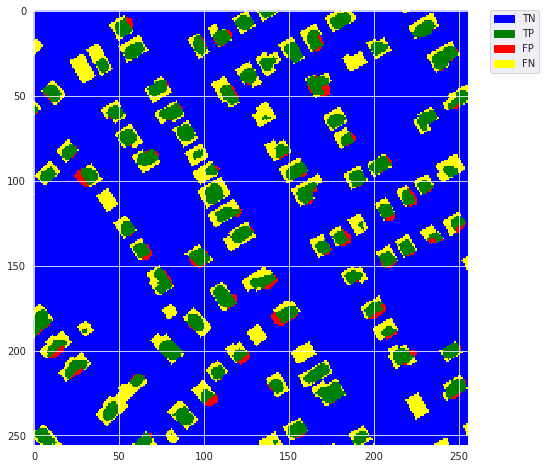

In [ ]:
values = np.array([0,1,2,3])
# Create a list of labels to use for your legend
class_labels = ["TN",
                "TP",
                "FP",
                "FN"]

# Create a colormap from a list of colors
class_colors = ['blue',
                'green',
                'red',
                'yellow']
plt.figure(figsize=(16,8))

cmap_ramp = colors.ListedColormap(class_colors)
im = plt.imshow(r_crosstab, interpolation='none',cmap=cmap_ramp)

# get the colors of the values, according to the 
# colormap used by imshow
colors_val = [ im.cmap(im.norm(value)) for value in values]
colors_val = class_colors
# create a patch (proxy artist) for every color 
patches = [ mpatches.Patch(color=class_colors[i], label=class_labels[i]) for i in range(len(values)) ]
# put those patched as legend-handles into the legend
plt.legend(handles=patches, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0. )

plt.grid(True)
plt.show()

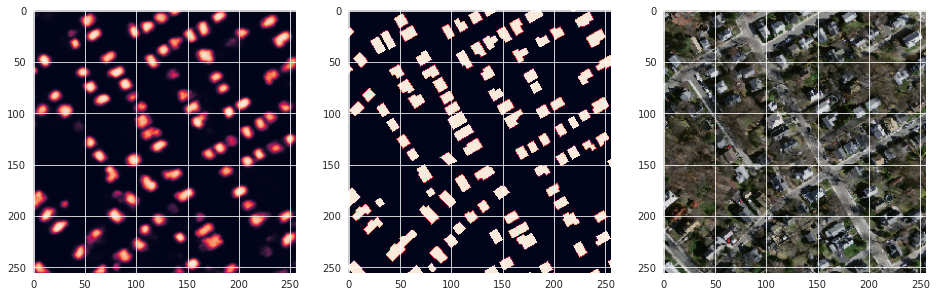

In [ ]:
f, ax = plt.subplots(1, 3,figsize=(16,16))

ax[0].imshow(Y_pred)
ax[1].imshow(Y_test)
ax[2].imshow(X_test)


<ipython-input-62-6f17e7027fdd>:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(Y_pred.ravel())


<Axes: ylabel='Density'>

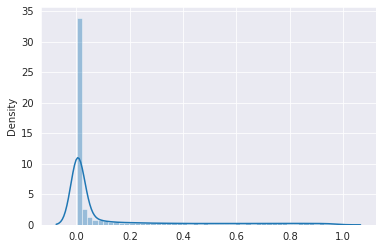

In [ ]:
sns.distplot(Y_pred.ravel())

AUC train:  nan
AUC test:  0.9562537492587228


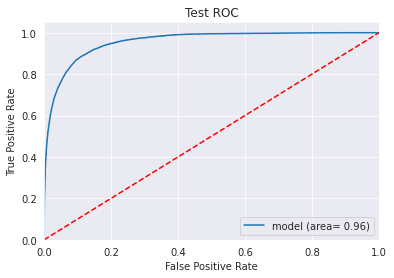

In [ ]:
roc_df, auc_df = plot_roc(y_test=Y_test.ravel(),
         y_scores_test=Y_pred.ravel(),
         y_scores_train=None,
         y_train=None,
         model_name=None,
         show_fig=True,
         out_file=None)

In [ ]:
list_auc_df = []
list_roc_df = []
for i in range(0,10):
    Y_pred = predictions[i]
    Y_test = w_Y_test[i]
    X_test = w_X_test[i]
    
    print('Batch number ',i)
    roc_df, auc_df = plot_roc(y_test=Y_test.ravel(),
         y_scores_test=Y_pred.ravel(),
         y_scores_train=None,
         y_train=None,
         model_name=None,
         show_fig=False,
         out_file=None)
    
    list_auc_df.append(auc_df)
    list_roc_df.append(roc_df)

Batch number  0
AUC train:  nan
AUC test:  0.8009254915603911
Batch number  1
AUC train:  nan
AUC test:  0.9562537492587228
Batch number  2
AUC train:  nan
AUC test:  0.9779397714281046
Batch number  3
AUC train:  nan
AUC test:  0.9368369747474373
Batch number  4
AUC train:  nan
AUC test:  0.9271380540465813
Batch number  5
AUC train:  nan
AUC test:  0.9808641408531511
Batch number  6
AUC train:  nan
AUC test:  0.9724712504982903
Batch number  7
AUC train:  nan
AUC test:  0.9815947167964182
Batch number  8
AUC train:  nan
AUC test:  0.9676736729588448
Batch number  9
AUC train:  nan
AUC test:  0.8923090187487397


In [ ]:
auc_df= pd.concat(list_auc_df)
#print(auc_df.test.mean())
auc_df

,test,train,model
0,0.8009254915603911,nan,model
0,0.9562537492587228,nan,model
0,0.9779397714281046,nan,model
0,0.9368369747474373,nan,model
0,0.9271380540465813,nan,model
0,0.9808641408531511,nan,model
0,0.9724712504982903,nan,model
0,0.9815947167964182,nan,model
0,0.9676736729588448,nan,model
0,0.8923090187487397,nan,model


In [ ]:
y_test=Y_test.ravel()
y_scores_test=Y_pred.ravel()

threshold = 0.5


Y_pred_cat = y_scores_test > threshold
Y_pred_cat= Y_pred_cat.astype('int')
Y_test_cat = y_test.astype('int')

report_dict=classification_report(Y_test_cat, 
                                  Y_pred_cat,
                                  output_dict=True)
report_df = pd.DataFrame(report_dict).transpose()
confusion_matrix_val = confusion_matrix(Y_test_cat,Y_pred_cat)

#https://towardsdatascience.com/what-metrics-should-we-use-on-imbalanced-data-set-precision-recall-roc-e2e79252aeba

In [ ]:
report_df

,precision,recall,f1-score,support
0,0.887420,0.999088,0.939949,54834.000000
1,0.986849,0.350589,0.517375,10702.000000
accuracy,0.893188,0.893188,0.893188,0.893188
macro avg,0.937135,0.674838,0.728662,65536.000000
weighted avg,0.903657,0.893188,0.870943,65536.000000



|             | Pred 0      | Pred 1     |
| :---        |    :----:   |       ---: |
| True 0      | TN          | FP         |
| True 1      | FN          | TP         |

- precision = TP/(TP+FP) 
- Recall = TP/(TP+FN) also called true positive rate or sensitivity, % of true positive cases recovered (not missed), if high a lot of misses
- FPR = FP/(FP+TN) , aslo called fall out FPR= 1- TNR
- TNR = TN/(TN+FP), also called specificity

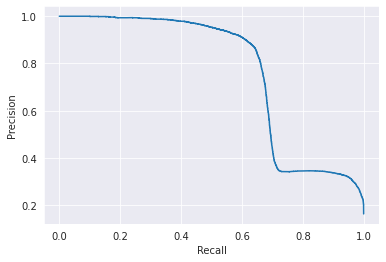

In [ ]:
# Use sklearn to plot precision-recall curves

from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
precision, recall, thresholds = precision_recall_curve(y_true=y_test, 
                       probas_pred=y_scores_test)

prd = PrecisionRecallDisplay(precision, recall)
prd.plot()

In [ ]:
thresholds = np.insert(thresholds,0,0)
precision_recall_df = pd.DataFrame.from_dict({'thresholds':thresholds,
                        'precision':precision,
                        'recall':recall,
                        })

(precision_recall_df)

0.970807
0.969984
1.000000
0.000000
0.970807


,thresholds,precision,recall
0,0.000000,0.163300,1.000000
1,0.000366,0.163302,1.000000
2,0.000396,0.163305,1.000000
3,0.000404,0.163307,1.000000
4,0.000420,0.163310,1.000000
...,...,...,...
65389,0.966286,1.000000,0.000374
65390,0.966556,1.000000,0.000280
65391,0.967538,1.000000,0.000187
65392,0.969984,1.000000,0.000093


In [ ]:
# add IOU and precision-recall curve
target = Y_test_cat
prediction = Y_pred_cat
intersection = np.logical_and(target, prediction)
union = np.logical_or(target, prediction)
iou_score = np.sum(intersection) / np.sum(union)
iou_score

0.3489583333333333

#6.Conclusions

In this exercise, we created a UNET model using tenserflow keras deep learning library to map built areas in Massachusets. We trained the model using TPU in colab (about 3 hours) and generated a map of errors and a series of ROC plot for the test data. We averaged over 0.95 for the AUC.
Here are few important points to note:

- the ROC curve may be misleading. It suggests good classification results but due to class imbalance (e.g. 16% pixel of building class in our example) the AUC is high (we predict no building easily. 
- testing on one image, we can see the recall is low (~0.35) suggesting we are missing a lot of pixels from building. This is visible as large yellow areas (False Negatives) on the image plotted.
- The precision-recall curve is more informative. It shows a drastic drop in precision without improvement of recall. This curve is far from the top left. This suggests the model needs more training or revision.

In [ ]:
############################# END OF SCRIPT ###################################